# Problem
In Singapore, public housing are named as the ubiquitious HDB flats. Due to the growing economy and land scarce nature of the island nature, property prices are on a general uptrend. Despite it being public housing, lease holders have the right to buy and sell their HDB flats allowing for a chance for profit.  
Despite public data on transaction prices being available, it is still a challenge to determine the right price to sell at. This data science project aims to identify the factors that influence real estate prices and hopes to develop a predictive model considering those factors to provide future sellers with a data informed pricing guide to sell at.

# Literature review
An NUS Study compares depreciation value between private leasehold, private freehold and HDB flats. It however does not provide a perspective of other factors. 
Property Guru & 99co provides transaction prices but do not determine what factors influence the prices.    

# Data Description
URA API source (https://www.ura.gov.sg/maps/api/#introduction) includes only Private residential/landed prices but not public housing transaction prices. The dataset may be relevant if there is an extension of the work to private housing.  
Data.gov.sg has a wealth of publicly available data. A trawl through the database yielded a residential resale prices to be a good fit to what is required. Its dataset includes Town, Flat type, Block, Street name, Storey range, Floor area sqm, Flat model, Lease commence date, Remaining lease. The 9 factors is presents a sufficiently wide range of factors for the purposes of the study.  
Foursquare API data can be used to ascertain nearby amenities and provide a supporting view1. The focus of the study will be on a regression model and thus will not apply the clustering methodology used in the course. It is the author's intention to explore methods beyond what was taught in the course rather than replicating the course steps. 



# Data Preprocessing

### Import transaction data from Data.gov.sg API

In [1]:
#Gets the data from the API
import urllib
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee'
# Open the URL as Browser, not as python urllib. Default guide provided by data.gov gives a 403 Forbidden error.
page=urllib.request.Request(url,headers={'User-Agent': 'Mozilla/5.0'}) 
infile=urllib.request.urlopen(page).read()
data = infile.decode('ISO-8859-1') # Read the content as string decoded with ISO-8859-1

In [2]:
#Transforms the data into a pandas dataframe
import pandas as pd
import json
df = pd.read_json(data)
results_df = df['result']['records'] #access the nested list for the records
json_string = json.dumps(results_df) #converts list to json for import into dataframe

hdb_df = pd.read_json(json_string)
hdb_df.head()


,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,ANG MO KIO,2 ROOM,Improved,44,ANG MO KIO AVE 10,232000,2017-01,61 years 04 months,1979,10 TO 12,1,406
1,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 4,250000,2017-01,60 years 07 months,1978,01 TO 03,2,108
2,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,262000,2017-01,62 years 05 months,1980,01 TO 03,3,602
3,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,265000,2017-01,62 years 01 month,1980,04 TO 06,4,465
4,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,265000,2017-01,62 years 05 months,1980,01 TO 03,5,601


### Understand the dataset

In [3]:
#Understand the data set
hdb_df.describe()
#Check for null values in the dataset
hdb_df.isnull().sum()

town                   0
flat_type              0
flat_model             0
floor_area_sqm         0
street_name            0
resale_price           0
month                  0
remaining_lease        0
lease_commence_date    0
storey_range           0
_id                    0
block                  0
dtype: int64

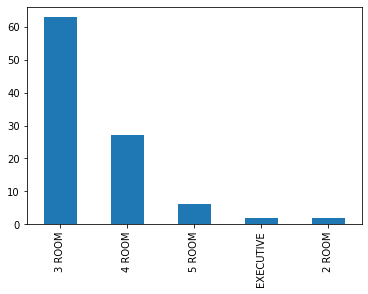

In [4]:
import matplotlib.pyplot as plt
hdb_df['flat_type'].value_counts().plot(kind='bar')

There is an obvious volume of 3 room flats in the data set for the period.

## Modelling

### Convert applicable data into numerical features for optimisation

Getting the remaining lease term

In [5]:
# Transform features to numeric for optimization# can I convert rooms and town? for future
#floor_area_sqm, lease_commence_date, storey_range 


##Getting years of remaining lease from current year. remaining_lease column is not accurate as its backgdate (pegged at the time when the api ran)
#Getting the current year
from datetime import date

current_date = date.today()
current_year = current_date.year

# Getting the lease commence date
hdb_df['remaining_lease_int'] = 99 - (current_year - hdb_df['lease_commence_date'])



Applying a median to the floor level to allow for optimisation

In [6]:
##Storey Range. Will be getting the middle of the storey range (i.e. 01 to 03 = 02, 10 to 12 = 11)
# Find the unique entries of the storey_range column
import numpy as np
hdb_df.storey_range.unique()

#replace storey range with medianized storeys
hdb_df['storey'] = hdb_df['storey_range'].replace({'10 TO 12': '11', '01 TO 03': '2', '04 TO 06': '5', '07 TO 09':'8', '13 TO 15':'14', '19 TO 21':'20', '22 TO 24':'23'}) #improve on this to be more repeatable
hdb_df['storey'] = hdb_df.storey.astype(np.int64)
hdb_df

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,remaining_lease_int,storey
0,ANG MO KIO,2 ROOM,Improved,44,ANG MO KIO AVE 10,232000,2017-01,61 years 04 months,1979,10 TO 12,1,406,57,11
1,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 4,250000,2017-01,60 years 07 months,1978,01 TO 03,2,108,56,2
2,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,262000,2017-01,62 years 05 months,1980,01 TO 03,3,602,58,2
3,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,265000,2017-01,62 years 01 month,1980,04 TO 06,4,465,58,5
4,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,265000,2017-01,62 years 05 months,1980,01 TO 03,5,601,58,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BEDOK,4 ROOM,New Generation,91,BEDOK NTH RD,380000,2017-01,60 years 05 months,1978,01 TO 03,95,80,56,2
96,BEDOK,4 ROOM,New Generation,91,BEDOK NTH RD,382000,2017-01,60 years 07 months,1978,04 TO 06,96,78,56,5
97,BEDOK,4 ROOM,Simplified,84,BEDOK RESERVOIR RD,384000,2017-01,69 years 02 months,1987,07 TO 09,97,135,65,8
98,BEDOK,4 ROOM,Simplified,84,BEDOK RESERVOIR RD,385000,2017-01,69 years 03 months,1987,13 TO 15,98,148,65,14


## Performing Linear Regression modelling

In [7]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Defining the value to be optimized(resale_price)
predictor = hdb_df[['resale_price']]
predictor

,resale_price
0,232000
1,250000
2,262000
3,265000
4,265000
...,...
95,380000
96,382000
97,384000
98,385000


In [8]:
#Defining the features for optimization
features = hdb_df[['storey','floor_area_sqm','remaining_lease_int']]
features

,storey,floor_area_sqm,remaining_lease_int
0,11,44,57
1,2,67,56
2,2,67,58
3,5,68,58
4,2,67,58
...,...,...,...
95,2,91,56
96,5,91,56
97,8,84,65
98,14,84,65


In [9]:
#Leave test size as default. use arbitary random_state 0 to get same result across different calls
x_train, x_test, y_train, y_test = train_test_split(features,predictor ,random_state=0)

In [10]:
# check on inputs 
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(75, 3) (75, 1)
(25, 3) (25, 1)


In [11]:
# Since it is likely to be a regression model, starting off with a linear regression first
linear_reg = linear_model.LinearRegression()
model = linear_reg.fit(x_train, y_train)

predictions = linear_reg.predict(x_test)
model.coef_ 


array([[4689.73945809, 5740.02445847, 6444.0021921 ]])

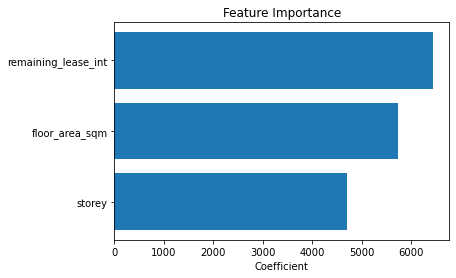

In [12]:
#FEATURE importance bar chart, SEARCH IF THIS IS THE RIGHT WAY
plt.barh(np.array(features.columns),model.coef_[0])
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.show()

The Linear regression model shows that although remaining lease has high importance in determining transaction prices, it is not very distinct from the other 2 factors (floor_area & storey)

### Plotting a scatter plot

Text(0, 0.5, 'Predictions')

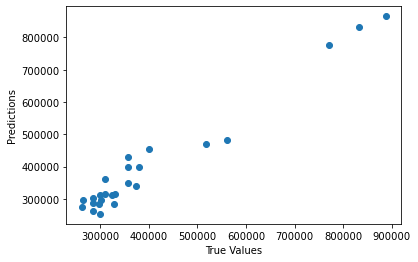

In [13]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [14]:
#Prints the R^2 of the prediction.
print ("Score:", model.score(x_test, y_test))

Score: 0.9609234411537675


The Rsq is at 96.1% which indicates that the linear regression model is relatively accurate in predicting transaction prices.

### Gradient Boost Regression

In [15]:
#Try the Gradient Boost regressor

from sklearn import ensemble
GBreg = ensemble.GradientBoostingRegressor(n_estimators = 500, max_depth=4, min_samples_split = 3, learning_rate=0.1, loss = 'ls')

In [16]:
GBreg.fit(x_train,y_train.values.ravel())

GradientBoostingRegressor(max_depth=4, min_samples_split=3, n_estimators=500)

In [17]:
print(GBreg.score(x_test,y_test))

0.9514292231963996


The Gradient Boost regression gives a Rsq of 95.1%. Although marginally lower than the linear regressor, it is still relatively accurate in prediciting transaction prices.

In [18]:
GBreg.feature_importances_

array([0.01424295, 0.76143573, 0.22432132])

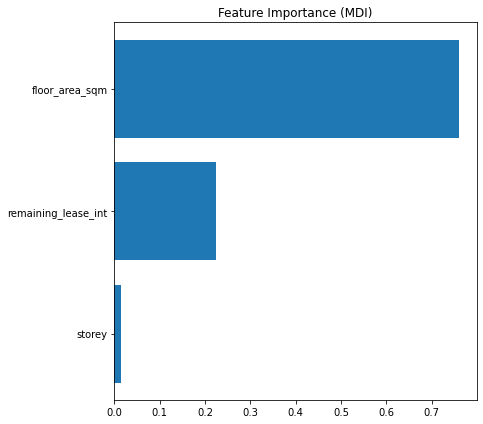

In [19]:
# Plotting Feature importance of GB Regression
feature_importance = GBreg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')


fig.tight_layout()
plt.show()

There is a more significant difference in feature importance from the Gradient boost regressor model. It reveals that floor area whilst previously being quite close in importance to lease, is now a dominant factor in determining transaction prices.  
It further differentiates and plays down the importance of the floor level (storey) in determining the transaction prices. This will be useful consideration in comparison should all other factors remain equal. 

# Analysis of venues from each area

In [20]:
#initialize the venue df
hdb_venue_df = pd.DataFrame()

hdb_venue_df['town']= hdb_df['town'].unique()
hdb_venue_df


,town
0,ANG MO KIO
1,BEDOK
2,BISHAN


There are only 3 towns with transactions for the dataset. Not surprising as SG is a small city and does not have many towns. The towns in the data set are also popular "mature" estates that affirms the transaction volumes. 

### Obtaining a list of venues for each town

In [21]:
#input town coordinates
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_796bdecadf3f4326b0afe947b25d86fa = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='LbrDOvRBqrZc_kfRvh_8CH_1VmxxNFSkGmibu5EZrlPA',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_796bdecadf3f4326b0afe947b25d86fa.get_object(Bucket='datasciencespecialization-donotdelete-pr-sadtxoioteptgv',Key='sg_Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,town,Latitude,Longitude
0,Ang Mo Kio,1.369115,103.845436
1,Bedok,1.324999,103.932368
2,Bishan,1.351912,103.848971


In [22]:
#make 'town' all caps to enable merge
df_data_1['town'] = df_data_1['town'].str.upper()
#merge both tables
venue_df = pd.merge(df_data_1, hdb_venue_df, on='town')
venue_df

,town,Latitude,Longitude
0,ANG MO KIO,1.369115,103.845436
1,BEDOK,1.324999,103.932368
2,BISHAN,1.351912,103.848971


### Pulling Venue from Foursquare 

In [23]:
#Foursquare credentials - Removed for sharing
CLIENT_ID = # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
ACCESS_TOKEN = # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

In [24]:
#function to get the name of the category
def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
import requests

for i in venue_df.index:
    
    town = venue_df['town'][i]
    print("----"+town+"----")
    lat =venue_df['Latitude'][i]
    lng =venue_df['Longitude'][i]
    radius = 1000 
    LIMIT = 10 
#     print(i,town,lat,lng)
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
    results = json.loads(requests.get(url).text)
    
    results = results['response']['groups'][0]['items']
    nearby = pd.json_normalize(results) # Flattens JSON

    # Filtering the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby = nearby.loc[:, filtered_columns]
    
    # Renaming the columns
    columns = ['Name', 'Category', 'Latitude', 'Longitude']
    nearby.columns = columns

    # Gets the categories
    nearby['Category'] = nearby.apply(get_category_type, axis=1)    

    #Group category by count
    grouped_nearby = nearby.groupby(nearby['Category']).count()
    
    grouped_nearby = grouped_nearby.drop(['Latitude','Longitude'], axis=1)
    grouped_nearby = grouped_nearby.rename(columns={'Name':'Count'})
    print(grouped_nearby)

----ANG MO KIO----
                     Count
Category                  
Asian Restaurant         1
Burger Joint             1
Japanese Restaurant      1
Noodle House             1
Park                     1
Ramen Restaurant         1
Snack Place              1
Spa                      1
Supermarket              2
----BEDOK----
                               Count
Category                            
Asian Restaurant                   1
Bakery                             1
Breakfast Spot                     1
Café                               1
Chinese Restaurant                 1
Coffee Shop                        1
Food Court                         1
Supermarket                        1
Thai Restaurant                    1
Vegetarian / Vegan Restaurant      1
----BISHAN----
                     Count
Category                  
Bookstore                1
Chinese Restaurant       1
Coffee Shop              1
Dumpling Restaurant      1
Food Court               1
Gym                   

Looking at the venues in each town, although it seems like there is a wide spread of categories, most of them can be classified as Food & Beverages (i.e restaurants, burger, food court, coffee shop, cafes, noodle house). Other than Food & Beverages, the unique venues for the towns are as follows:  

•	Ang Mo Kio: Park, Spa, Supermarket  
•	Bedok: Supermarket  
•	Bishan: Bookstore, Gym, Pool, Stadium  

From the venues data, all 3 towns have a wide variety of places to eat. Buyers that are looking for more recreational facilities can look to Bishan where there are sports facilities like gyms, pools and stadiums. A neighborhood covering more needs would be Ang Mo Kio where there are recreational (Park & Spa) and amenities(supermarket) as well. Bedok has a supermarket but the venues do not reveal amenities in the neighborhood.  

## Conclusion  
From the regression models feature importance chart, all else being equal, when deciding on the premium to sell a HDB flat at, sellers should focus on their units’ floor area and remaining lease rather than placing a premium on the level at which their unit was located. Although it is commonly regarded that every storey level brings a premium, the model reveals that whilst that may be true in certain cases, the floor area and years of remaining lease are the key features in determining a selling price.  

Given that it has a high predictive accuracy, potential flat sellers can utilize the linear regression model developed to get a data backed estimate of a reasonable selling price base on the features of the flat.    

This project has provided a data informed pricing model to guide sellers on HDB prices to sell at. It has answered the problem statement and identified the key features influencing HDB transaction prices namely (floor area & years of remaining lease). It has also provided a categorisation of venues type to provide a perspective on the venues in each neighborhood to better inform HDB flat purchases. Clients now have an improved decision making in evaluating the impact of different factors to the price of flat for buying/selling evaluation.



## Learnings  
Data science does not have to be a linearly progressing problem solving method. Rather than wrestle with trying to get the right problem and data, focus first on a simple problem and develop a Minimum Viable Output from it. As you dive deep, more questions will surface to mind. Park these aside for future exploration into your backlog and focus on developing your MVOutput.  
Once the MVOutput is done and you have a better grasp of your steps, data sources and questions to ask, embark on another MVOutput iteration to beef up your analysis. The analysis will refine with the iterations or perhaps certain MVOs will become shippable as its own standalone reports.
Nothing is wasted!